# Chest X-rays
Identifying and assessing structures in the lung from X-ray scans of the chest is an essential task across multiple diseases involving the lungs and upper abdomen, e.g., lung cancer infections, pnemonia, broken ribs, and more. X-ray images can provide a detailed view of the lungs surrounding structures, making it possible to detect, analyze, monitor and assess treatment response. Computer-aided diagnostic tools addressing chest X-rays are important in medical imaging, possibly increasing speed, accuracy, consistency, and cost-effectiveness.

The goal for the project consisted of two smaller goals. One, create a deep learning system to detect one or more of 14 conditions directly from one or more chest X-rays. And two, investigate and apply techniques for "Explainable AI".

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chexpert-v10-small/CheXpert-v1.0-small/valid.csv
/kaggle/input/chexpert-v10-small/CheXpert-v1.0-small/train.csv
/kaggle/input/chexpert-v10-small/CheXpert-v1.0-small/valid/patient64611/study1/view1_frontal.jpg
/kaggle/input/chexpert-v10-small/CheXpert-v1.0-small/valid/patient64545/study1/view1_frontal.jpg
/kaggle/input/chexpert-v10-small/CheXpert-v1.0-small/valid/patient64711/study1/view1_frontal.jpg
/kaggle/input/chexpert-v10-small/CheXpert-v1.0-small/valid/patient64612/study1/view1_frontal.jpg
/kaggle/input/chexpert-v10-small/CheXpert-v1.0-small/valid/patient64684/study1/view1_frontal.jpg
/kaggle/input/chexpert-v10-small/CheXpert-v1.0-small/valid/patient64648/study1/view1_frontal.jpg
/kaggle/input/chexpert-v10-small/CheXpert-v1.0-small/valid/patient64682/study1/view1_frontal.jpg
/kaggle/input/chexpert-v10-small/CheXpert-v1.0-small/valid/patient64587/study1/view1_frontal.jpg
/kaggle/input/chexpert-v10-small/CheXpert-v1.0-small/valid/patient64558/study1/view2_lateral.jpg
/

In [3]:
#basic fastai import
from pathlib import Path
from fastai.data.all import *
from fastai.vision.all import *

In this classifier I desided to use a different approach then from the first classifier, here I used the FastBook from the fastai flipped classroom course that was part of the compendium in the DAT255 Deep Learning course. Here I used a similar apporach as the one that was done in the task that was given to make a bear classifier.

In [15]:
#the observations that I want to make predictions on and use for classification
observations = 'No finding', 'Enlarged Cardiomediatinum', 'Cardiomeagly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pnemothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices'

In [23]:
path = Path('/kaggle/input/chexpert-v10-small/CheXpert-v1.0-small/train')

In [24]:
#making a datablock to prepare the images for training
obs = DataBlock(blocks = (ImageBlock, CategoryBlock), get_items = get_image_files, 
                get_y=parent_label, 
               item_tfms=Resize(128))

In [25]:
dl = obs.dataloaders(path)

**Looking at and exploring the data**
Trying different methods of reshaping the pictures to see if some are better than others.

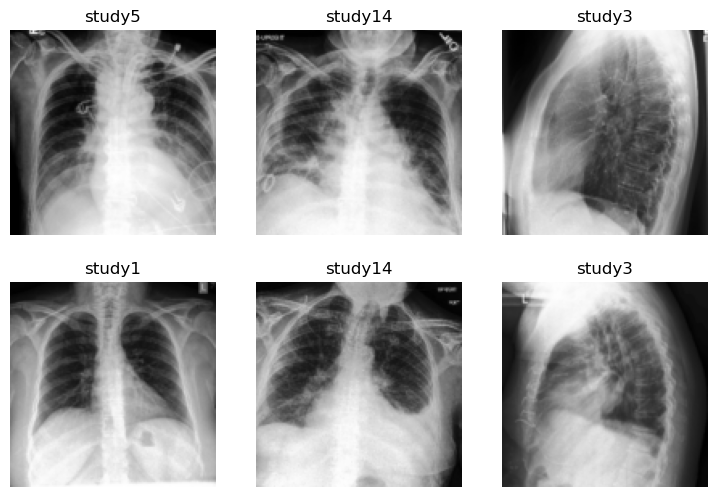

In [26]:
#Here I check the output of my data so far, and at looking back at my code now, I should have spotted the mistake in the labeling of my original dataset
dl.valid.show_batch(max_n=6, nrows=2)

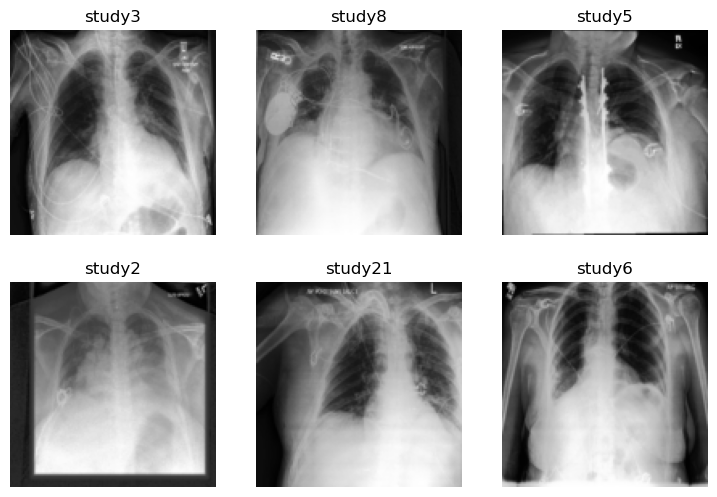

In [27]:
#Here I try to squish the images to see if that make them clearer, but I do not think so
obs = obs.new(item_tfms=Resize(128, ResizeMethod.Squish))
dl = obs.dataloaders(path)
dl.valid.show_batch(max_n=6, nrows=2)

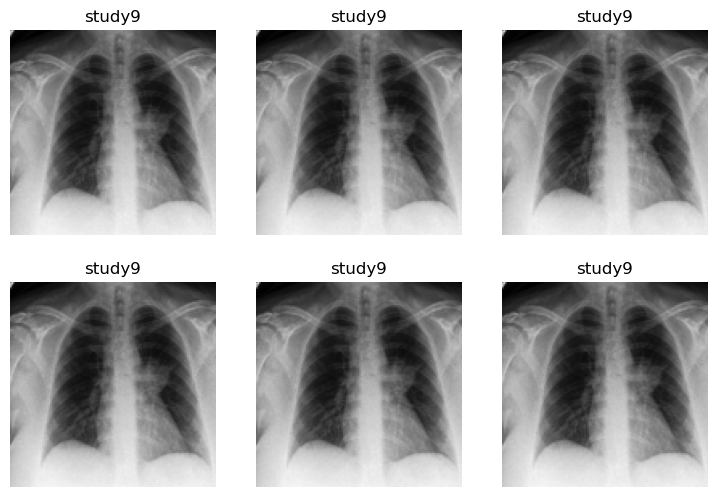

In [28]:
#Here I try to crop the pictures, but to be honest I see no effect what so ever
obs = obs.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dl=obs.dataloaders(path)
dl.valid.show_batch(max_n=6, nrows=2, unique=True)

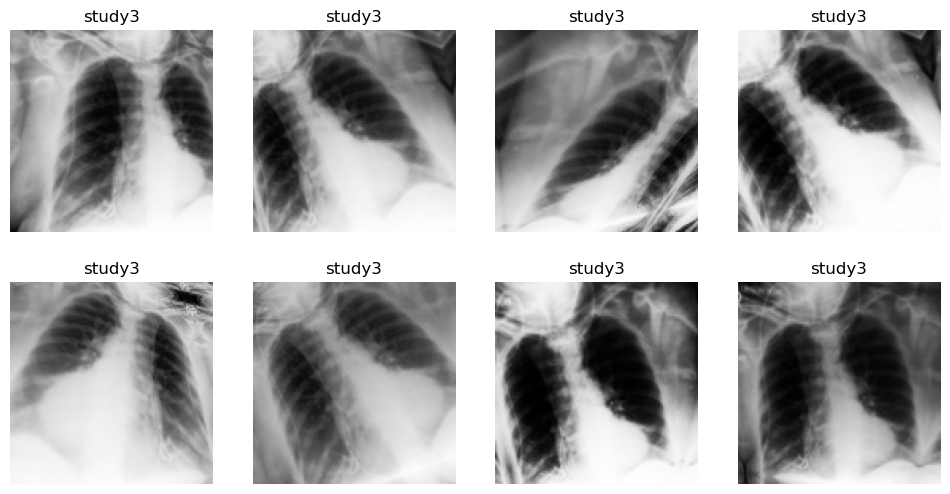

In [29]:
#Here I try a method that takes the input and returns it in different angles and depths
obs=obs.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dl = obs.dataloaders(path, bs=64)
dl.train.show_batch(max_n=8, nrows=2, unique=True)

In [30]:
##prepearing the data for the test later, this is an unnecesary step for recreating my model due to the problems I faced with the dataset. The problems are discused in the project report
chest = obs.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms=aug_transforms())
dl = chest.dataloaders(path)

In [31]:
#initiate the training
learn = vision_learner(dl, resnet34, metrics=accuracy)
learn.fine_tune(11)

KeyError: Caught KeyError in DataLoader worker process 1.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/fastai/data/transforms.py", line 261, in encodes
    return TensorCategory(self.vocab.o2i[o])
KeyError: 'study90'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 43, in fetch
    data = next(self.dataset_iter)
  File "/opt/conda/lib/python3.7/site-packages/fastai/data/load.py", line 138, in create_batches
    yield from map(self.do_batch, self.chunkify(res))
  File "/opt/conda/lib/python3.7/site-packages/fastcore/basics.py", line 230, in chunked
    res = list(itertools.islice(it, chunk_sz))
  File "/opt/conda/lib/python3.7/site-packages/fastai/data/load.py", line 153, in do_item
    try: return self.after_item(self.create_item(s))
  File "/opt/conda/lib/python3.7/site-packages/fastai/data/load.py", line 160, in create_item
    if self.indexed: return self.dataset[s or 0]
  File "/opt/conda/lib/python3.7/site-packages/fastai/data/core.py", line 458, in __getitem__
    res = tuple([tl[it] for tl in self.tls])
  File "/opt/conda/lib/python3.7/site-packages/fastai/data/core.py", line 458, in <listcomp>
    res = tuple([tl[it] for tl in self.tls])
  File "/opt/conda/lib/python3.7/site-packages/fastai/data/core.py", line 417, in __getitem__
    return self._after_item(res) if is_indexer(idx) else res.map(self._after_item)
  File "/opt/conda/lib/python3.7/site-packages/fastai/data/core.py", line 377, in _after_item
    def _after_item(self, o): return self.tfms(o)
  File "/opt/conda/lib/python3.7/site-packages/fastcore/transform.py", line 208, in __call__
    def __call__(self, o): return compose_tfms(o, tfms=self.fs, split_idx=self.split_idx)
  File "/opt/conda/lib/python3.7/site-packages/fastcore/transform.py", line 158, in compose_tfms
    x = f(x, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/fastcore/transform.py", line 81, in __call__
    def __call__(self, x, **kwargs): return self._call('encodes', x, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/fastcore/transform.py", line 91, in _call
    return self._do_call(getattr(self, fn), x, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/fastcore/transform.py", line 97, in _do_call
    return retain_type(f(x, **kwargs), x, ret)
  File "/opt/conda/lib/python3.7/site-packages/fastcore/dispatch.py", line 120, in __call__
    return f(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/fastai/data/transforms.py", line 263, in encodes
    raise KeyError(f"Label '{o}' was not included in the training dataset") from e
KeyError: "Label 'study90' was not included in the training dataset"


In [21]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

KeyError: Caught KeyError in DataLoader worker process 1.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/fastai/data/transforms.py", line 261, in encodes
    return TensorCategory(self.vocab.o2i[o])
KeyError: 'study64'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 43, in fetch
    data = next(self.dataset_iter)
  File "/opt/conda/lib/python3.7/site-packages/fastai/data/load.py", line 138, in create_batches
    yield from map(self.do_batch, self.chunkify(res))
  File "/opt/conda/lib/python3.7/site-packages/fastcore/basics.py", line 230, in chunked
    res = list(itertools.islice(it, chunk_sz))
  File "/opt/conda/lib/python3.7/site-packages/fastai/data/load.py", line 153, in do_item
    try: return self.after_item(self.create_item(s))
  File "/opt/conda/lib/python3.7/site-packages/fastai/data/load.py", line 160, in create_item
    if self.indexed: return self.dataset[s or 0]
  File "/opt/conda/lib/python3.7/site-packages/fastai/data/core.py", line 458, in __getitem__
    res = tuple([tl[it] for tl in self.tls])
  File "/opt/conda/lib/python3.7/site-packages/fastai/data/core.py", line 458, in <listcomp>
    res = tuple([tl[it] for tl in self.tls])
  File "/opt/conda/lib/python3.7/site-packages/fastai/data/core.py", line 417, in __getitem__
    return self._after_item(res) if is_indexer(idx) else res.map(self._after_item)
  File "/opt/conda/lib/python3.7/site-packages/fastai/data/core.py", line 377, in _after_item
    def _after_item(self, o): return self.tfms(o)
  File "/opt/conda/lib/python3.7/site-packages/fastcore/transform.py", line 208, in __call__
    def __call__(self, o): return compose_tfms(o, tfms=self.fs, split_idx=self.split_idx)
  File "/opt/conda/lib/python3.7/site-packages/fastcore/transform.py", line 158, in compose_tfms
    x = f(x, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/fastcore/transform.py", line 81, in __call__
    def __call__(self, x, **kwargs): return self._call('encodes', x, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/fastcore/transform.py", line 91, in _call
    return self._do_call(getattr(self, fn), x, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/fastcore/transform.py", line 97, in _do_call
    return retain_type(f(x, **kwargs), x, ret)
  File "/opt/conda/lib/python3.7/site-packages/fastcore/dispatch.py", line 120, in __call__
    return f(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/fastai/data/transforms.py", line 263, in encodes
    raise KeyError(f"Label '{o}' was not included in the training dataset") from e
KeyError: "Label 'study64' was not included in the training dataset"


In [ ]:
interp.plot_top_losses(5, nrows=1)

# Credits
*done by a student*
https://www.kaggle.com/code/hoturam/bear-classifier-fastai-98

https://www.kaggle.com/code/jhoward/saving-a-basic-fastai-model

https://github.com/fastai/fastbook/blob/master/02_production.ipynb